In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
import seaborn as sns
from scipy import stats


In [2]:
# Import data
aal = pd.read_csv("~/Projects/wqu/MScFE650/GWA1/RawData/AAL.csv", delimiter=',')
aal['Date'] = pd.to_datetime(aal['Date'], format="%d/%m/%Y")
aal['Date_'] = aal['Date']
#  aal.set_index('Date', inplace=True)


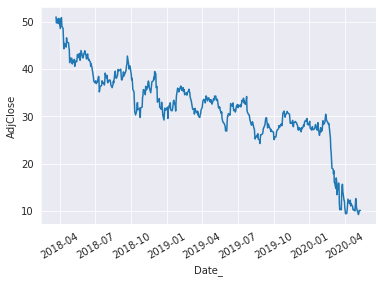

In [3]:
sns.set_style('darkgrid')
sns.lineplot(x='Date_', y='AdjClose', data=aal)
plt.xticks(rotation=30)
plt.show()
#  aal['AdjClose'].plot(figsize=(16/12))


In [4]:
# Calculate Return, Log Return
def nans(shape, dtype=float):
    # To generate nans array
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

def shift(price_array, n):
    # n is the number shift to the right
    result = nans(len(price_array))
    for i in range(n,len(price_array)):
        result[i] = price_array[i-n]
    return result

def normal_neturn(P_f, P_i):
    result = (P_f - P_i)/P_i
    return result

def log_return(P_f, P_i):
    result = np.log(P_f/P_i)
    return result


In [5]:
# Calculate mean and standard deviation
aal['Normal_Return'] = normal_neturn(aal['AdjClose'],shift(aal['AdjClose'],1))
aal['Log_Return'] = log_return(aal['AdjClose'],shift(aal['AdjClose'],1))

price_mean = aal['AdjClose'].mean()
price_std = aal['AdjClose'].std()

return_mean = aal['Normal_Return'].mean()
return_std = aal['Normal_Return'].std()

log_return_mean = aal['Log_Return'].mean()
log_return_std = aal['Log_Return'].std()


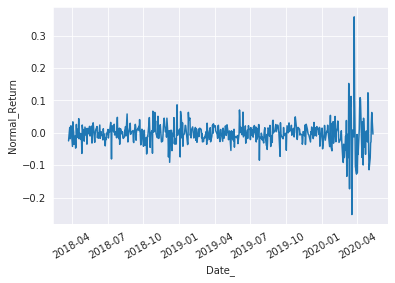

In [6]:
sns.set_style('darkgrid')
sns.lineplot(x='Date_', y='Normal_Return', data=aal)
plt.xticks(rotation=30)
plt.show()


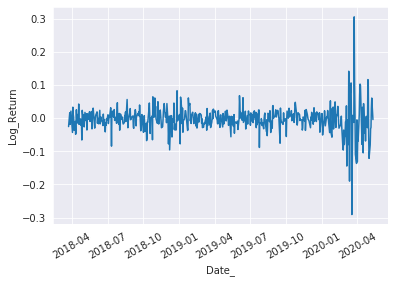

In [7]:
sns.set_style('darkgrid')
sns.lineplot(x='Date_', y='Log_Return', data=aal)
plt.xticks(rotation=30)
plt.show()



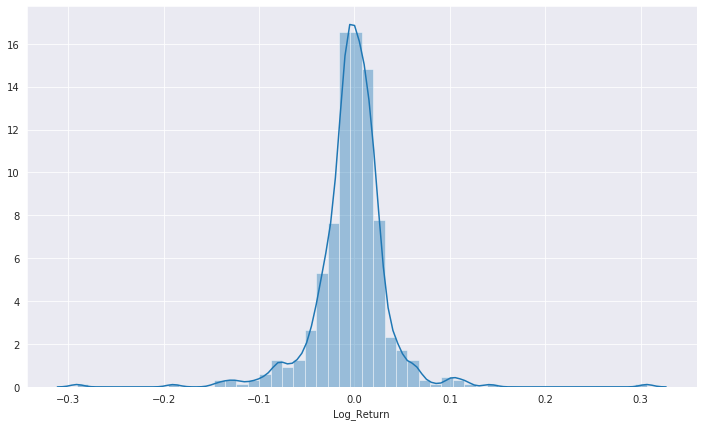

In [8]:
# Dist plot for Log_Return
plt.figure(figsize=(12,7))
ax = sns.distplot(aal['Log_Return'])
plt.show()

In [9]:
# Calculate SMA(25) ad EWMA_25
aal['SMA25_Price'] = aal['AdjClose'].rolling(window=25).mean()
aal['SMA25_Log_Return'] = aal['Log_Return'].rolling(window=25).mean()
aal['EWMA_25_Price'] = aal['AdjClose'].ewm(com=25).mean()
aal['EWMA_10_Price'] = aal['AdjClose'].ewm(com=10).mean()

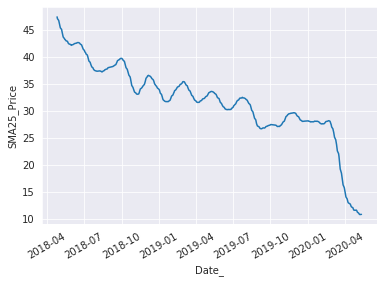

In [10]:
# SMA_25_For_Adj_Close
sns.set_style('darkgrid')
sns.lineplot(x='Date_', y='SMA25_Price', data=aal)
plt.xticks(rotation=30)
plt.show()

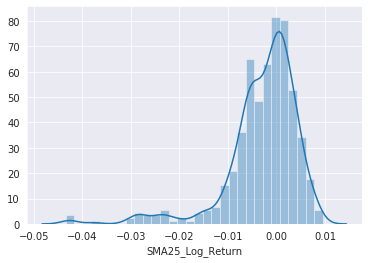

In [11]:
# SMA_25_For_Adj_Close
ax = sns.distplot(aal['SMA25_Log_Return'])
plt.show()

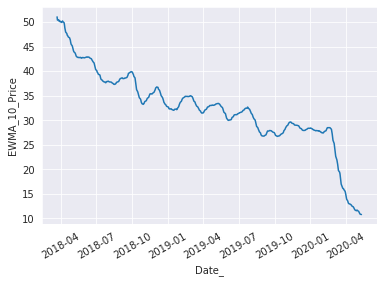

In [12]:
sns.set_style('darkgrid')
sns.lineplot(x='Date_', y='EWMA_10_Price', data=aal)
plt.xticks(rotation=30)
plt.show()

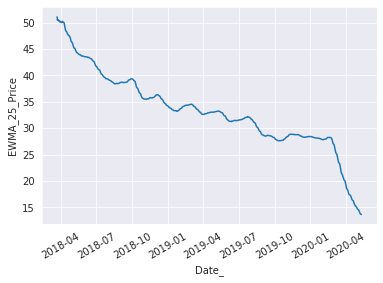

In [13]:
sns.set_style('darkgrid')
sns.lineplot(x='Date_', y='EWMA_25_Price', data=aal)
plt.xticks(rotation=30)
plt.show()

In [14]:
# Structural break chow_test
# https://medium.com/@remycanario17/the-chow-test-dealing-with-heterogeneity-in-python-1b9057f0f07a
# Look at our graph, we can easily see that there is a structure break in Feb
# 2020. So we will test linear regression with y1, y2 break from 1 Feb 2020
# because of corona virus
# Note that we won't use linear regression in our return
import numpy as np
from scipy.stats import f

def f_value(y1, x1, y2, x2):
    """ In favor of joshualong. f_value function for Chow Break test package

    :y1: Array like y-values for data preceeding the breakpoint
    :x1: Array like x-values for data preceeding the breakpoint
    :y2: Array like y-values for data occuring after the breakpoint
    :x2: Array like x-values for data occuring after the breakpoint
    :return: F-value: Float value of chow break test

    """
    def find_rss(y, x):
        """This is the subfunction to find the residual sum of squares for a 
        given set of data
        :y: Array like y-values for data subset
        :x: Array like x-values for data subset
        :Returns:
            rss: Returns residual sum of squares of the linear equation 
            represented by that data
            length: The number of n terms that the data represents
        """
        # Preparetion with np.ones to stack and transpose for linear regression
        A = np.vstack ([x, np.ones(len(x))]).T
        # Least squares solution
        rss = np.linalg.lstsq(A, y, rcond=None)[1]
        length = len(y)
        return (rss, length)

    rss_total, n_total = find_rss(np.append(y1, y2), np.append(x1, x2))
    rss_1, n_1 = find_rss(y1, x1)
    rss_2, n_2 = find_rss(y2, x2)
    
    chow_nom = (rss_total - (rss_1 + rss_2)) / 2
    chow_denom = (rss_1 + rss_2) / (n_1 + n_2 - 4)

    return chow_nom / chow_denom

def p_value(y1, x1, y2, x2, **kwargs):
    F = f_value(y1, x1, y2, x2, **kwargs)
    if not F:
        return 1
    df1 = 2
    df2 = len(x1) + len(x2) - 4

    # The survival function (1-cdf) is more precise than using 1-cdf,
    # this helps when p-values are very close to zero.
    # -f.logsf would be another alternative to directly get -log(pval) instead.
    p_val = f.sf(F[0], df1, df2)
    return p_val



In [18]:
# Case 1: with breakdown in 1-Feb-2020
y1 = aal[aal['Date_'] < '2020-02-01']['AdjClose']
x1 = np.array(aal[aal['Date_'] < '2020-02-01'].index)
y2 = aal[aal['Date_'] >='2020-02-01']['AdjClose']
x2 = np.array(aal[aal['Date_'] >= '2020-02-01'].index)

f_test = f_value(y1, x1, y2, x2)
p_val = p_value(y1, x1, y2, x2)
print(f_test)
print(p_val)
# => p-value = 3.148814751321537e-84 < 0.0005
# Structural break at Feb 2020 

[281.59555375]
3.148814751321537e-84


In [19]:

# Case 2: with breakdown in 13-Feb-2020
y1 = aal[aal['Date_'] < '2020-02-13']['AdjClose']
x1 = np.array(aal[aal['Date_'] < '2020-02-13'].index)
y2 = aal[aal['Date_'] >='2020-02-13']['AdjClose']
x2 = np.array(aal[aal['Date_'] >= '2020-02-13'].index)

f_test = f_value(y1, x1, y2, x2)
p_val = p_value(y1, x1, y2, x2)
print(f_test)
print(p_val)
# => p-value = 3.2.8240389745107666e-84 < 0.0005

[281.81926606]
2.8240389745107666e-84


In [20]:
# Bera-Jarque
stats.jarque_bera(np.array(aal['AdjClose']))

(65.35501859679724, 6.439293542825908e-15)